<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/RFMiD2ResNetNov10v1cfg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Details - not working - model will not fit:

" ValueError: `logits` and `labels` must have the same shape, received "

Dataset: RFMiD2.0 - multidisease (5) classification

Model: ResNet18 FCNN

Adapted from coursera - Retinopathy Detection Using Deep Learning

 https://www.coursera.org/learn/retinopathy-detection-using-deep-learning/supplement/em4yb/project-based-course-overview



In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import glob
import PIL
from PIL import Image
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 10 02:06:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
# Download the dataset zip archive
!curl -o /content/drive/MyDrive/downloads/RFMiD2_0.zip https://zenodo.org/records/7505822/files/RFMiD2_0.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.7M  100 60.7M    0     0  46.0M      0  0:00:01  0:00:01 --:--:-- 46.0M


In [6]:
# Unzip the archive
!unzip /content/drive/MyDrive/downloads/RFMiD2_0.zip -d /content/drive/MyDrive/cfPublicData/RFMiD2
!ls

Archive:  /content/drive/MyDrive/downloads/RFMiD2_0.zip
  inflating: /content/drive/MyDrive/cfPublicData/RFMiD2/Test_set.zip  
  inflating: /content/drive/MyDrive/cfPublicData/RFMiD2/Training_set.zip  
  inflating: /content/drive/MyDrive/cfPublicData/RFMiD2/Validation_set.zip  
drive  RFMiD2_0.zip  sample_data  Test_set.zip	Training_set.zip  Validation_set.zip


In [ ]:
!unzip /content/drive/MyDrive/cfPublicData/RFMiD2/Test_set.zip -d /content/drive/MyDrive/cfPublicData/RFMiD2/Test_set
!unzip /content/drive/MyDrive/cfPublicData/RFMiD2/Training_set.zip -d /content/drive/MyDrive/cfPublicData/RFMiD2/Training_set
!unzip /content/drive/MyDrive/cfPublicData/RFMiD2/Validation_set.zip -d /content/drive/MyDrive/cfPublicData/RFMiD2/Validation_set


In [8]:
# List of directories to rename files
directories = ['/content/drive/MyDrive/cfPublicData/RFMiD2/Test_set',
               '/content/drive/MyDrive/cfPublicData/RFMiD2/Training_set',
               '/content/drive/MyDrive/cfPublicData/RFMiD2/Validation_set']

for directory in directories:
    # Get list of .JPG files in the directory
    files = glob.glob(directory + '/*.JPG')

    # Rename each file
    for file in files:
        base = os.path.splitext(file)[0]
        os.rename(file, base + '.jpg')


In [9]:

# List of directories to move files from
directories = ['/content/drive/MyDrive/cfPublicData/RFMiD2/Test_set',
               '/content/drive/MyDrive/cfPublicData/RFMiD2/Training_set',
               '/content/drive/MyDrive/cfPublicData/RFMiD2/Validation_set']

# Destination directory
destination = '/content/drive/MyDrive/cfPublicData/RFMiD2'

for directory in directories:
    # Get list of .csv files in the directory
    files = glob.glob(directory + '/*.csv')

    # Move each file
    for file in files:
        shutil.move(file, destination)


In [ ]:
# Create dataframe from image/diagnosis datafile
df_train = pd.read_csv("/content/drive/MyDrive/cfPublicData/RFMiD2/RFMiD_2_Training_labels.csv", encoding='ISO-8859-1')
df_test = pd.read_csv("/content/drive/MyDrive/cfPublicData/RFMiD2/RFMiD_2_Testing_labels.csv", encoding='ISO-8859-1')
df_valid = pd.read_csv("/content/drive/MyDrive/cfPublicData/RFMiD2/RFMiD_2_Validation_labels.csv", encoding='ISO-8859-1')

print("Training",df_train.shape)
print("Validation",df_valid.shape)
print("Test",df_test.shape)

In [17]:

print("Training",df_train.head(5))
print("Validation",df_valid.head(5))
print("Test",df_test.head(5))

Training    ID  WNL  AH  AION  ARMD  BRVO  CB  CF  CL  CME  ...  RT  SOFE  ST  TD  \
0   1    0   0     0     0     0   0   0   0    0  ...   0     0   0   0   
1   2    0   0     0     0     0   0   0   0    1  ...   0     0   0   0   
2   3    0   0     0     0     0   0   0   0    0  ...   0     0   0   0   
3   4    0   0     0     0     0   0   0   0    1  ...   0     0   0   0   
4   5    0   0     0     0     0   0   0   0    0  ...   0     0   0   0   

   TSLN  TV  VS  HTN  IIH  Unnamed: 52  
0     0   0   0    0    0          NaN  
1     0   0   0    0    0          NaN  
2     0   0   0    0    0          NaN  
3     0   0   0    0    0          NaN  
4     0   0   0    0    0          NaN  

[5 rows x 53 columns]
Validation     ID  WNL  AH  AION  ARMD  BRVO  CB  CF  CL  CME  ...  RT  SOFE  ST  TD  \
0    6    0   0     0     0     0   0   0   0    0  ...   0     0   0   0   
1   25    0   0     0     0     0   0   0   0    0  ...   0     0   0   0   
2   65    0   0     0  

In [18]:
df_train = df_train.iloc[:, :-1]
df_test = df_test.iloc[:, :-1]
df_valid = df_valid.iloc[:, :-1]
print("Training",df_train.shape)
print("Validation",df_valid.shape)
print("Test",df_test.shape)

Training (509, 52)
Validation (177, 52)
Test (174, 52)


In [19]:
# List of directories to move files from
directories = ['/content/drive/MyDrive/cfPublicData/RFMiD2/Test_set',
               '/content/drive/MyDrive/cfPublicData/RFMiD2/Training_set',
               '/content/drive/MyDrive/cfPublicData/RFMiD2/Validation_set']

# Destination directory
destination = '/content/drive/MyDrive/cfPublicData/RFMiD2/train_images'

for directory in directories:
    # Get list of all .jpg files in the directory
    files = glob.glob(directory + '/*.jpg')

    # Move each file
    for file in files:
        shutil.move(file, destination)



In [20]:
# count files
directory = '/content/drive/MyDrive/cfPublicData/RFMiD2/train_images'

# Get list of all files in the directory
files = glob.glob(directory + '/*')

# Print the number of files
print(len(files))


860


In [21]:
import pandas as pd

# Assuming df_train, df_test, df_valid are your dataframes
df = pd.concat([df_train, df_test, df_valid])
print(df.shape)

(860, 52)


In [22]:
df.head()

ID  WNL  AH  AION  ARMD  BRVO  CB  CF  CL  CME  ...  RS  RT  SOFE  ST  TD  \
0   1    0   0     0     0     0   0   0   0    0  ...   0   0     0   0   0   
1   2    0   0     0     0     0   0   0   0    1  ...   0   0     0   0   0   
2   3    0   0     0     0     0   0   0   0    0  ...   0   0     0   0   0   
3   4    0   0     0     0     0   0   0   0    1  ...   0   0     0   0   0   
4   5    0   0     0     0     0   0   0   0    0  ...   0   0     0   0   0   

   TSLN  TV  VS  HTN  IIH  
0     0   0   0    0    0  
1     0   0   0    0    0  
2     0   0   0    0    0  
3     0   0   0    0    0  
4     0   0   0    0    0  

[5 rows x 52 columns]

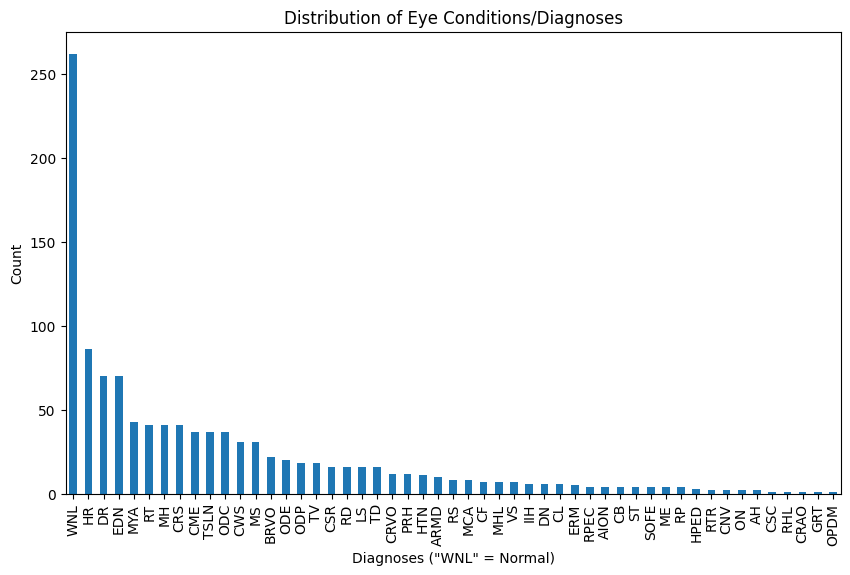

In [26]:
# Distribution of conditions / diseases
class_counts = df.iloc[:, 1:].sum()  # Exclude ID column and sum each class column

# Sort in descending order
class_counts = class_counts.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Eye Conditions/Diagnoses')
plt.xlabel('Diagnoses ("WNL" = Normal)')
plt.ylabel('Count')
plt.show()


In [ ]:
# Get the names of the 5 most common classes
top_5_classes = class_counts.index[:5].tolist()

# Include 'ID' in the list of columns to keep
columns_to_keep = ['ID'] + top_5_classes

# Filter the dataframe
df_filtered = df[columns_to_keep]

df_filtered.head()

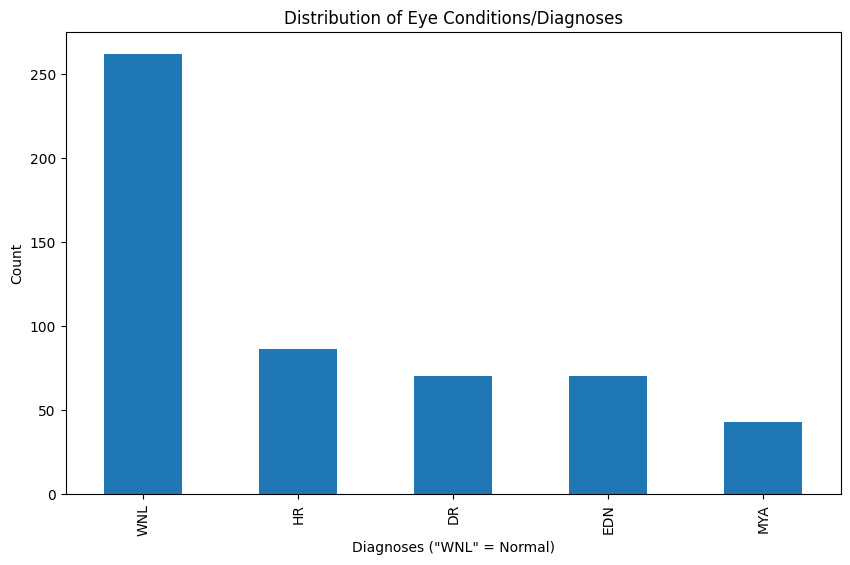

In [53]:
# Distribution of conditions / diseases
class_counts = df_filtered.iloc[:, 1:].sum()  # Exclude ID column and sum each class column

# Sort in descending order
class_counts = class_counts.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Eye Conditions/Diagnoses')
plt.xlabel('Diagnoses ("WNL" = Normal)')
plt.ylabel('Count')
plt.show()

In [54]:
# cross-reference dataframe with image folder to check if any image files are missing, and delete them from the df


# Directory to check files
directory = '/content/drive/MyDrive/cfPublicData/RFMiD2/train_images'

# For each ID in df_filtered
for id in df_filtered['ID']:
    # Define the image file path
    image_file_path = f'{directory}/{id}.jpg'

    # If the image file does not exist
    if not os.path.isfile(image_file_path):
        # Drop the row from df_filtered
        df_filtered = df_filtered[df_filtered['ID'] != id]



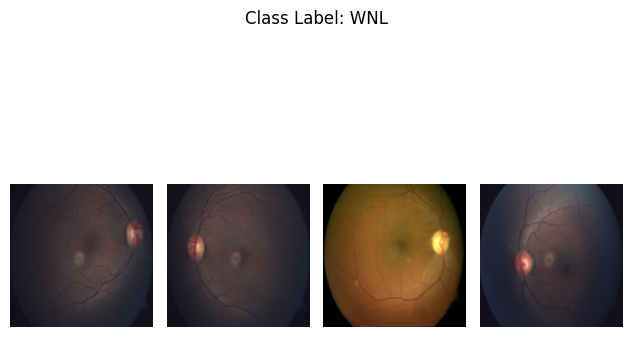

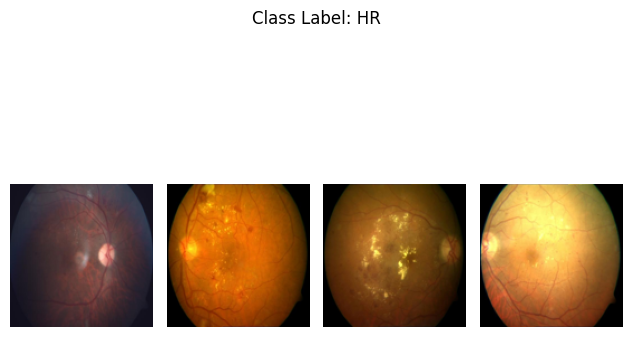

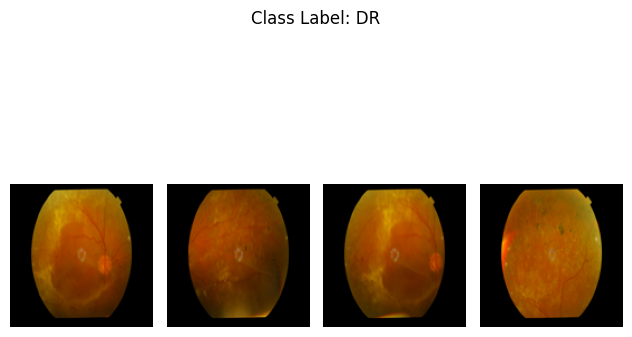

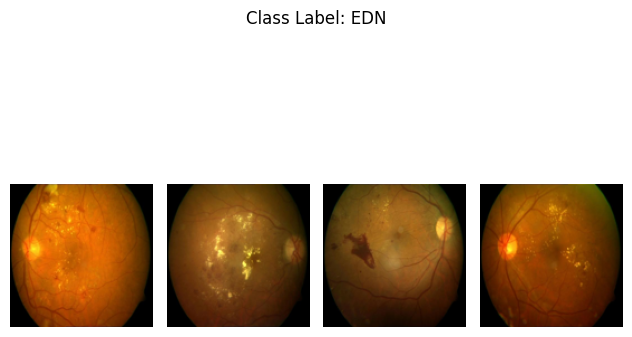

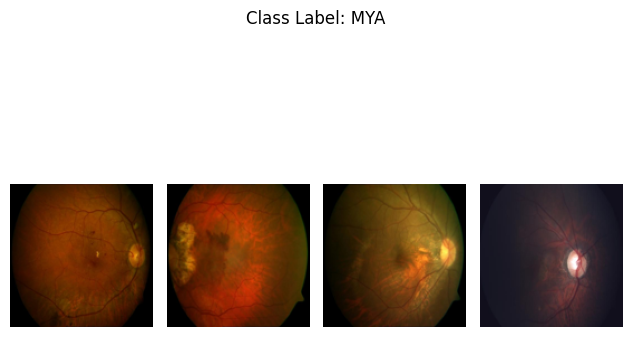

In [55]:
# Get the class labels
class_labels = df_filtered.columns[1:]

# Define the size for the images
size = (128, 128)

# For each class label
for label in class_labels:
    # Get the IDs of the first 4 images that have this class label
    image_ids = df_filtered[df_filtered[label] == 1]['ID'].head(4)

    # For each image ID
    for i, image_id in enumerate(image_ids):
        # Define the image file path
        image_file_path = f'/content/drive/MyDrive/cfPublicData/RFMiD2/train_images/{image_id}.jpg'

        # If the image file exists
        if os.path.isfile(image_file_path):
            # Open the image file
            image = Image.open(image_file_path)

            # Resize the image
            image = image.resize(size)

            # Create a subplot for this image
            plt.subplot(1, 4, i+1)
            plt.imshow(image)
            plt.axis('off')
        else:
            print(f"Image file not found: {image_file_path}")

    # Show the plot for this class label
    plt.suptitle(f'Class Label: {label}')
    plt.tight_layout(pad=1.0)  # Adjust the pad parameter as needed
    plt.show()


In [56]:
# Get the class labels
class_labels = df_filtered.columns[1:]

# For each class label
for label in class_labels:
    # Get the count of values equal to 1 for this class label
    count = (df_filtered[label] == 1).sum()

    # Print the count
    print(f'Class Label: {label}, Count of 1s: {count}')




Class Label: WNL, Count of 1s: 261
Class Label: HR, Count of 1s: 85
Class Label: DR, Count of 1s: 70
Class Label: EDN, Count of 1s: 70
Class Label: MYA, Count of 1s: 43


In [66]:
# Create a copy of df_filtered
retina_df = df_filtered.copy()

# Modify the "Image" column
retina_df['Image'] = '/content/drive/MyDrive/cfPublicData/RFMiD2/train_images/' + retina_df['ID'].astype(str) + '.jpg'

# Drop the 'ID' column
retina_df = retina_df.drop(columns=['ID'])

# Make 'Image' the first column
cols = ['Image']  + [col for col in retina_df if col != 'Image']
retina_df = retina_df[cols]

retina_df.head()


Image  WNL  HR  DR  EDN  MYA
0  /content/drive/MyDrive/cfPublicData/RFMiD2/tra...    0   1   0    0    0
1  /content/drive/MyDrive/cfPublicData/RFMiD2/tra...    0   0   0    0    0
2  /content/drive/MyDrive/cfPublicData/RFMiD2/tra...    0   1   0    1    0
3  /content/drive/MyDrive/cfPublicData/RFMiD2/tra...    0   1   0    1    0
4  /content/drive/MyDrive/cfPublicData/RFMiD2/tra...    0   0   0    1    0

In [67]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size =0.2)

In [68]:
# Data augmentation on training and test datasets
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal and vertical flip
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split = 0.15)

# Normalize test data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [69]:
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col=["WNL", "HR", "DR", "EDN", "MYA"],
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="multi_output",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col=["WNL", "HR", "DR", "EDN", "MYA"],
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="multi_output",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col=["WNL", "HR", "DR", "EDN", "MYA"],
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="multi_output",
    batch_size=32)


Found 583 validated image filenames.
Found 102 validated image filenames.
Found 172 validated image filenames.


In [96]:
# ResNet configuration
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [101]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')


In [72]:
# Display Model
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 128, 128, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1[0][0]']        

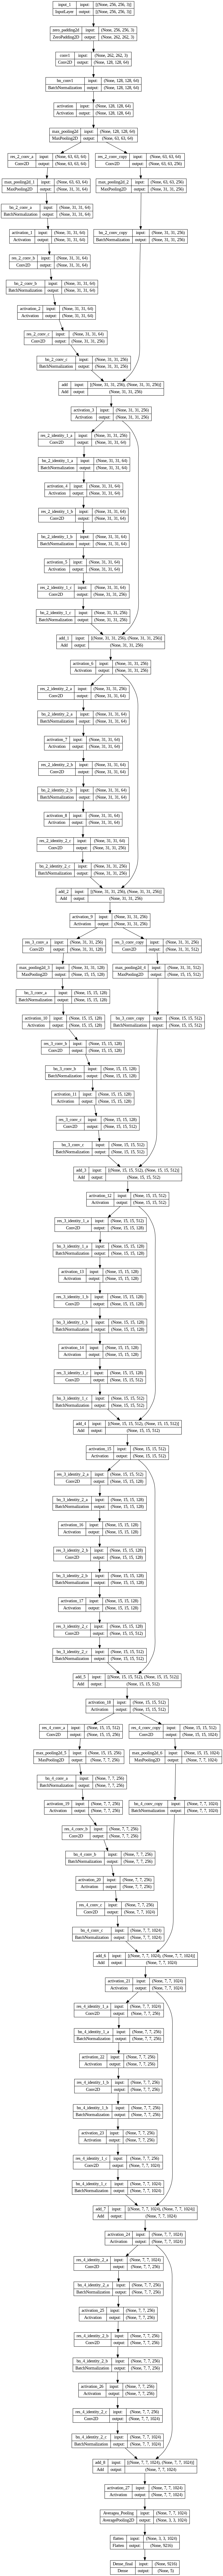

In [73]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [98]:
# Compile Model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])

In [99]:
#apply early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lowest validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/cfPublicData/aptos2/weights.hdf5", verbose=1, save_best_only=True)

In [86]:
print(len(train_generator.labels))


5


In [102]:
X

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Dense_final')>

In [100]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 2, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/2


ValueError: ignored

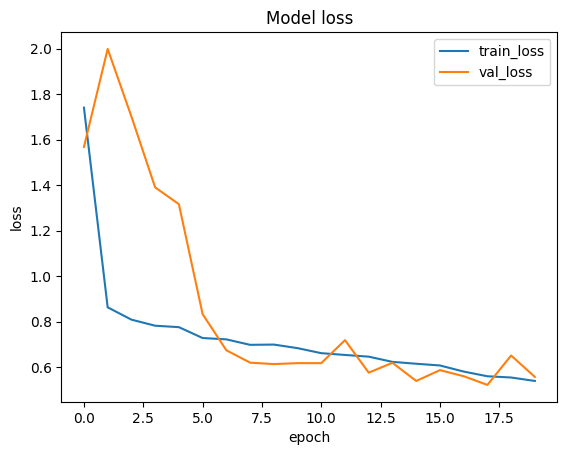

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()


In [ ]:
model.load_weights("/content/drive/MyDrive/cfPublicData/aptos2/retina_weights.hdf5")

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 [==============================] - 590s 28s/step - loss: 0.5096 - accuracy: 0.8253
Accuracy Test : 0.8252840638160706


In [ ]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No DR', 3:'Proliferative DR', 4: 'Severe'}


In [ ]:
# Loading images and their predictions

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


In [ ]:
# Getting the test accuracy
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8281036834924966


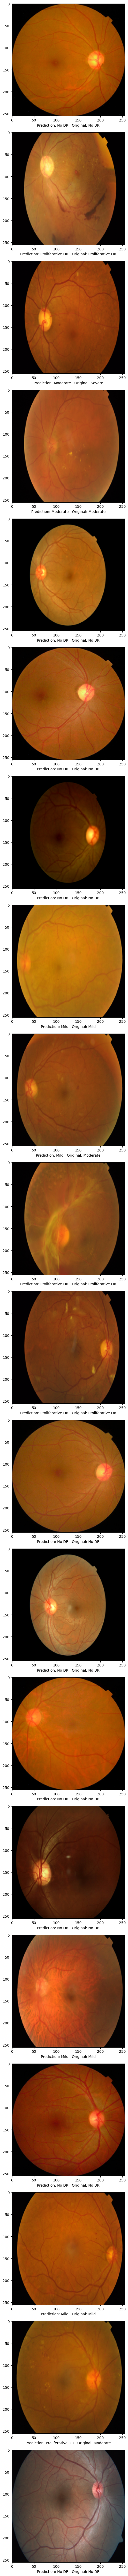

In [ ]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))


                  precision    recall  f1-score   support

            Mild       0.69      0.56      0.61        63
        Moderate       0.72      0.82      0.77       198
           No DR       0.95      0.97      0.96       380
Proliferative DR       0.57      0.54      0.56        57
          Severe       0.69      0.26      0.37        35

        accuracy                           0.83       733
       macro avg       0.72      0.63      0.66       733
    weighted avg       0.82      0.83      0.82       733



Text(0.5, 1.0, 'Confusion_matrix')

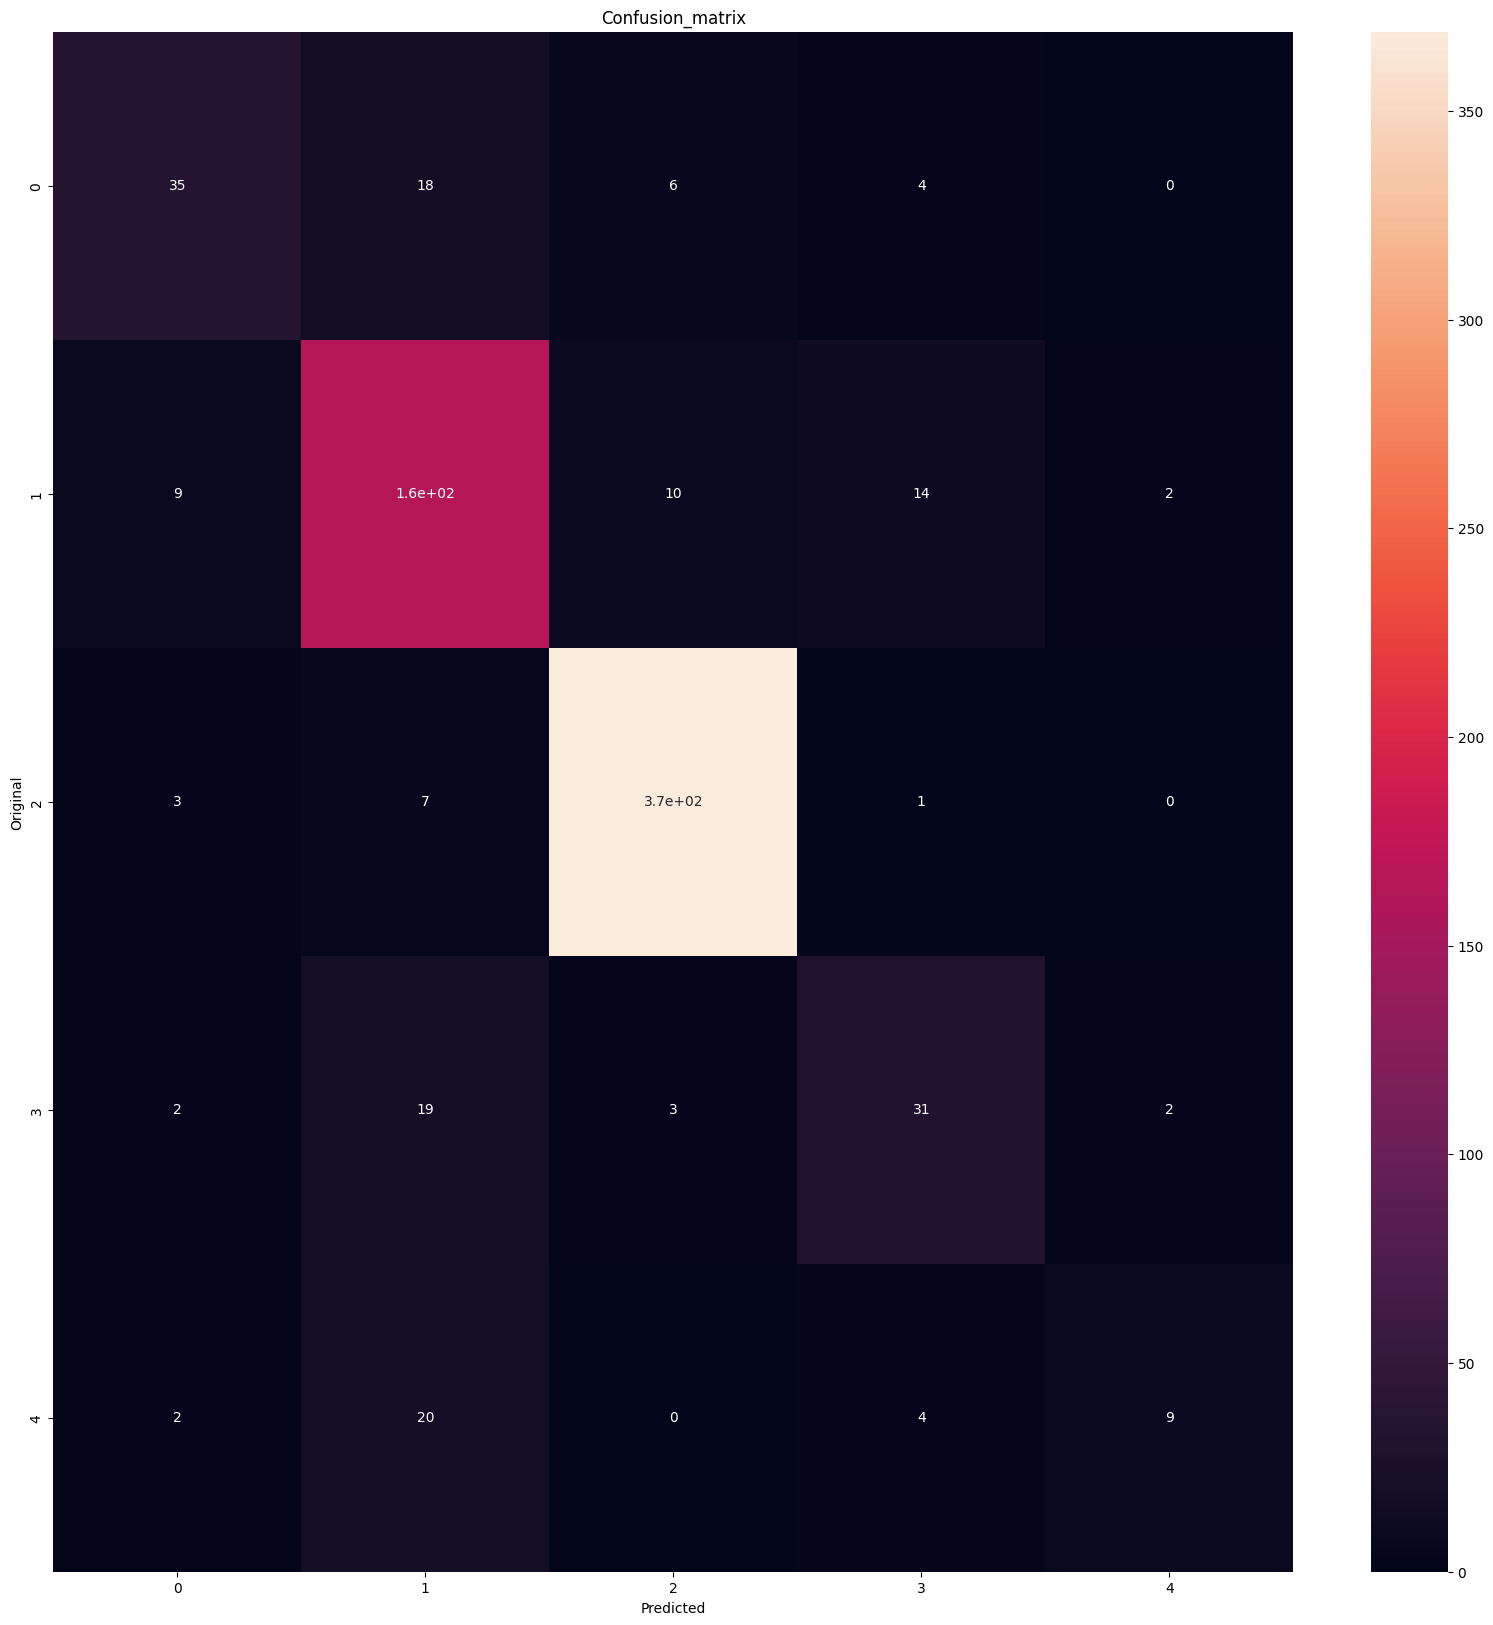

In [ ]:
plt.figure(figsize =(20,20))
cm = confusion_matrix(np.asarray(original), np.asanyarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')